In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit, when, unix_timestamp, datediff, max as spark_max, sum as spark_sum, count as spark_count, current_date, window, to_timestamp

spark = SparkSession.builder \
    .appName("EcommercePySparkAnalysis") \
    .getOrCreate()

INPUT_CSV = "gs://6893_lsxx/ecommerce1/2020-Mar.csv"

data_schema = StructType([
    StructField("event_time", TimestampType(), True),
    StructField("event_type", StringType(), True),
    StructField("product_id", IntegerType(), True),
    StructField("category_id", IntegerType(), True),
    StructField("category_code", StringType(), True),
    StructField("brand", StringType(), True),
    StructField("price", FloatType(), True),
    StructField("user_id", IntegerType(), True),
    StructField("user_session", StringType(), True)
])

try:
    df = spark.read.csv(
        INPUT_CSV, 
        header=True, 
        schema=data_schema, 
        timestampFormat="yyyy-MM-dd HH:mm:ss 'UTC'"
    )
    
    df = df.withColumnRenamed("user_session", "session_id")
    print("PySpark DataFrame loaded successfully.")
    print(f"Initial DataFrame count: {df.count()}")
    df.printSchema()
except Exception as e:
    print(f"Error loading data: {e}")

PySpark DataFrame loaded successfully.


Initial DataFrame count: 56341241
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: integer (nullable = true)
 |-- category_code: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- price: float (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- session_id: string (nullable = true)



In [ ]:
# Filter valid types
VALID_EVENT_TYPES = ['view', 'cart', 'remove_from_cart', 'purchase']
df = df.filter(col("event_type").isin(VALID_EVENT_TYPES))

df = df.na.fill({'brand': 'unknown', 'category_code': 'unknown'}) # Fill missing with unknown
df = df.filter(col("price").isNotNull())
df = df.filter(col("price") > 0)
df.cache()
df.createOrReplaceTempView("events_view")

print("Data cleaning and initial preprocessing complete.")
print(f"Cleaned and Cached DataFrame count: {df.count()}")

25/12/11 03:43:18 WARN CacheManager: Asked to cache already cached data.


Data cleaning and initial preprocessing complete.
Cleaned and Cached DataFrame count: 56274333



[Stage 109:================================================>      (52 + 3) / 59]



In [ ]:
from pyspark.sql.functions import date_format, lead, lag, row_number, dayofweek, hour
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit, when, unix_timestamp, datediff, max as spark_max, min as spark_min, sum as spark_sum, count as spark_count, current_date, window, to_timestamp

# Time-based features
df = df.withColumn("event_hour", hour(col("event_time"))) \
       .withColumn("event_dayofweek", dayofweek(col("event_time"))) \
       .withColumn("event_weekday_name", date_format(col("event_time"), "E"))

# Calculate session duration
session_window = Window.partitionBy("session_id").orderBy(col("event_time"))

# Find min and max event_time for each session
df_sessions = df.groupBy("session_id").agg(
    spark_min("event_time").alias("session_start"),
    spark_max("event_time").alias("session_end"),
    spark_count(lit(1)).alias("events_in_session")
)

# Calculate duration
df_sessions = df_sessions.withColumn(
    "session_duration_seconds",
    (unix_timestamp(col("session_end")) - unix_timestamp(col("session_start")))
)

# Merge session duration features
df = df.join(df_sessions.select("session_id", "session_duration_seconds", "events_in_session"),
             on="session_id", how="left")

print("Time and Session features engineered.")
df.select("event_time", "event_hour", "session_duration_seconds", "events_in_session").show(5, False)

Time and Session features engineered.


+-------------------+----------+------------------------+-----------------+
|event_time         |event_hour|session_duration_seconds|events_in_session|
+-------------------+----------+------------------------+-----------------+
|2020-03-15 04:26:59|4         |2554                    |64               |
|2020-03-17 14:01:38|14        |574                     |7                |
|2020-03-31 16:57:47|16        |21                      |3                |
|2020-03-04 19:21:13|19        |1074                    |61               |
|2020-03-25 15:14:54|15        |482                     |9                |
+-------------------+----------+------------------------+-----------------+
only showing top 5 rows



/tmp/ipykernel_14786/3282030386.py:23: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='event_type', y='count', data=event_counts_df, palette="viridis")


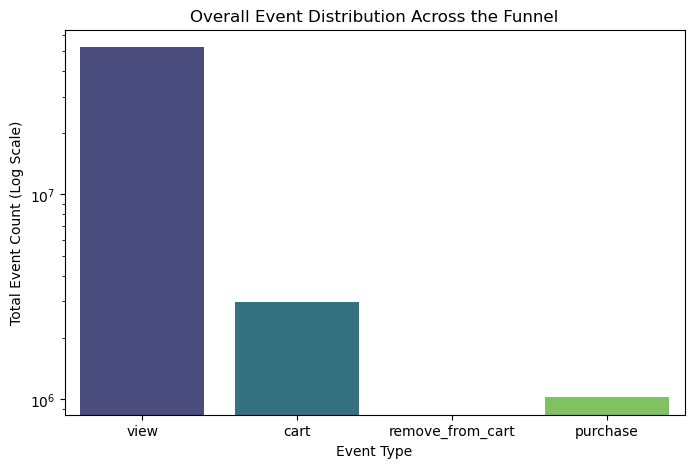

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from pyspark.sql.functions import approx_count_distinct

# Visualization
# Funnel chart
event_counts_df = df.groupBy("event_type").agg(spark_count(lit(1)).alias("count")) \
                    .filter(col("event_type").isin(VALID_EVENT_TYPES)) \
                    .toPandas() 

event_order = ['view', 'cart', 'remove_from_cart', 'purchase']
event_counts_df = event_counts_df.set_index('event_type').reindex(event_order).reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='event_type', y='count', data=event_counts_df, palette="viridis")
plt.title('Overall Event Distribution Across the Funnel')
plt.xlabel('Event Type')
plt.ylabel('Total Event Count (Log Scale)')
plt.yscale('log')
plt.show()

In [ ]:
import pandas as pd

snapshot_date = df.select(spark_max(col("event_time"))).collect()[0][0].date()
snapshot_date_lit = to_timestamp(lit(snapshot_date + pd.Timedelta(days=1))) # Use +1 day as the snapshot date
df_purchase = df.filter(col("event_type") == "purchase")

# RFM
rfm_df = df_purchase.groupBy("user_id").agg(
    # Recency
    datediff(snapshot_date_lit, spark_max(col("event_time"))).alias("Recency"),
    # Frequency
    spark_count(lit(1)).alias("Frequency"),
    # Monetary
    spark_sum(col("price")).alias("Monetary")
)

print("\nRFM Feature Calculation Complete.")
rfm_df.orderBy(col("Monetary").desc()).show(5)
rfm_df.createOrReplaceTempView("rfm_view")


RFM Feature Calculation Complete.


+---------+-------+---------+------------------+
|  user_id|Recency|Frequency|          Monetary|
+---------+-------+---------+------------------+
|595104624|      6|      389| 527776.7771911621|
|610871788|      1|      209|254009.45937538147|
|624819201|      9|      142|206238.02378845215|
|542157411|      4|      229|198634.76923942566|
|626212229|     17|      213|185189.29040527344|
+---------+-------+---------+------------------+
only showing top 5 rows




[Stage 125:============================>                            (2 + 2) / 4]



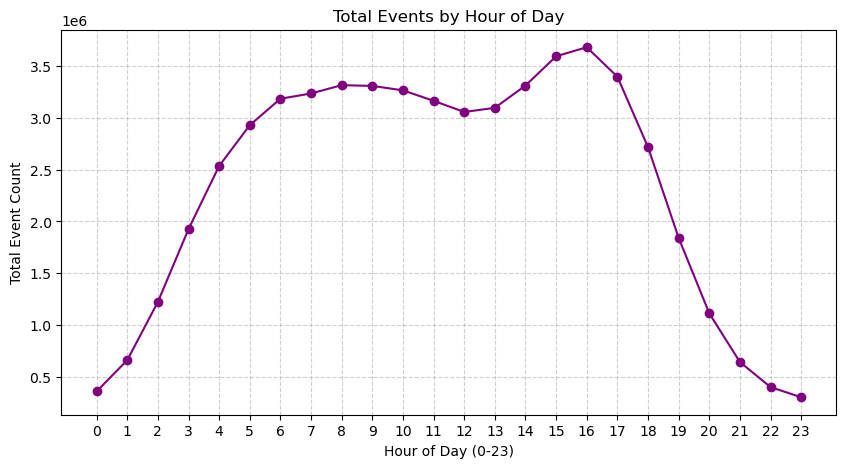

/tmp/ipykernel_14786/3484659459.py:33: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='event_weekday_name', y='count', data=daily_activity_pd, palette="rocket")


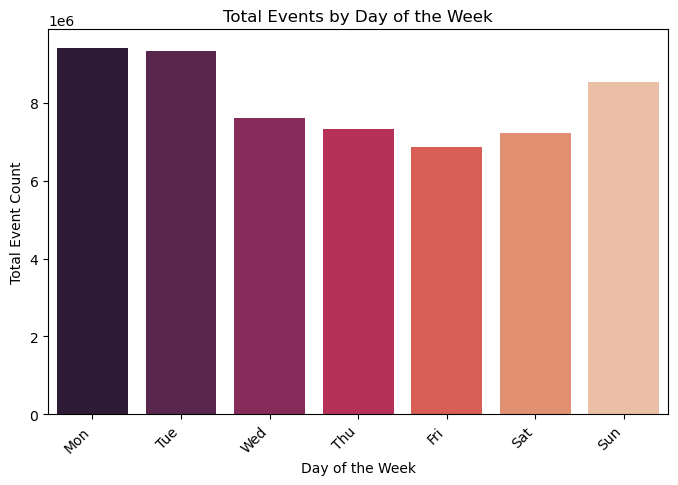

/tmp/ipykernel_14786/3484659459.py:51: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='category_code', data=top_categories_purchase_pd, palette="cubehelix")


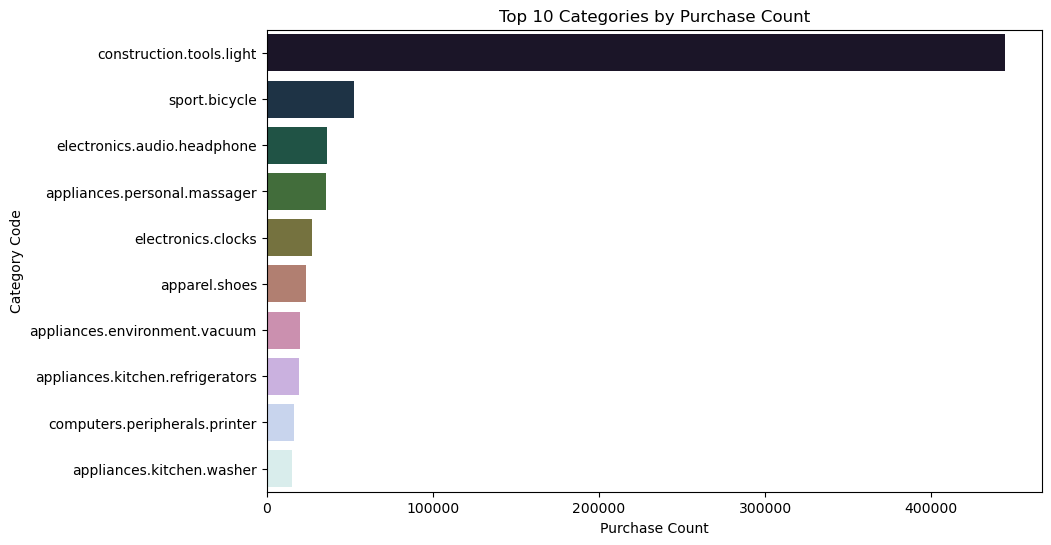

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Hourly activity
hourly_activity = df.groupBy("event_hour").agg(spark_count(lit(1)).alias("count")).orderBy("event_hour")
hourly_activity_pd = hourly_activity.toPandas()

plt.figure(figsize=(10, 5))
plt.plot(hourly_activity_pd['event_hour'], hourly_activity_pd['count'], marker='o', color='purple')
plt.title('Total Events by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Total Event Count')
plt.xticks(range(24))
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Weekday activity
daily_activity = df.groupBy("event_weekday_name").agg(spark_count(lit(1)).alias("count"))
daily_activity_pd = daily_activity.toPandas()
weekday_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'] 
daily_activity_pd['event_weekday_name'] = pd.Categorical(daily_activity_pd['event_weekday_name'],
                                                         categories=weekday_order, ordered=True)
daily_activity_pd = daily_activity_pd.sort_values('event_weekday_name')

plt.figure(figsize=(8, 5))
sns.barplot(x='event_weekday_name', y='count', data=daily_activity_pd, palette="rocket")
plt.title('Total Events by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Event Count')
plt.xticks(rotation=45, ha='right')
plt.show()


# Top-10 categories
top_categories_purchase = df.filter(col("event_type") == "purchase") \
                            .filter(col("category_code") != "unknown") \
                            .groupBy("category_code").agg(spark_count(lit(1)).alias("count")) \
                            .orderBy(col("count").desc()) \
                            .limit(10)
top_categories_purchase_pd = top_categories_purchase.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='category_code', data=top_categories_purchase_pd, palette="cubehelix")
plt.title('Top 10 Categories by Purchase Count')
plt.xlabel('Purchase Count')
plt.ylabel('Category Code')
plt.show()

In [ ]:
from pyspark.sql.functions import avg, coalesce

user_features = df.groupBy("user_id").agg(
    # Event counts
    spark_count(when(col("event_type") == "view", True)).alias("count_view"),
    spark_count(when(col("event_type") == "cart", True)).alias("count_cart"),
    spark_count(when(col("event_type") == "remove_from_cart", True)).alias("count_remove_from_cart"),
    spark_count(when(col("event_type") == "purchase", True)).alias("count_purchase"),
    # Average prices
    avg(when(col("event_type") == "view", col("price"))).alias("avg_price_view"),
    avg(when(col("event_type") == "cart", col("price"))).alias("avg_price_cart"),
    # Average session duration
    avg("session_duration_seconds").alias("avg_session_duration")
)

user_features = user_features.na.fill(0.0) # missing value

# User make a purchase
user_features = user_features.withColumn(
    "target_purchased",
    when(col("count_purchase") > 0, 1).otherwise(0)
)

print("Feature set for Purchase Prediction ready.")
user_features.show(5)

Feature set for Purchase Prediction ready.


+---------+----------+----------+----------------------+--------------+------------------+-----------------+--------------------+----------------+
|  user_id|count_view|count_cart|count_remove_from_cart|count_purchase|    avg_price_view|   avg_price_cart|avg_session_duration|target_purchased|
+---------+----------+----------+----------------------+--------------+------------------+-----------------+--------------------+----------------+
|632259343|         7|         0|                     0|             0| 395.3999982561384|              0.0|              1008.0|               0|
|516759071|        44|         0|                     0|             0|  261.288406198675|              0.0|   637.4772727272727|               0|
|617739918|       422|        29|                     0|             1|111.78199053940615|72.35655156497297|     817.45796460177|               1|
|515406162|        85|         3|                     0|             0| 795.9628217584947| 644.586669921875|   545.295

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
import pandas as pd 

feature_cols = [
    "count_view",
    "count_cart",
    "avg_price_view",
    "avg_price_cart",
    "avg_session_duration"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_vector")
scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features", withStd=True, withMean=True)
lr = LogisticRegression(featuresCol="scaled_features", labelCol="target_purchased", maxIter=5)
pipeline = Pipeline(stages=[assembler, scaler, lr])

(trainingData, testData) = user_features.sample(False, 0.1, seed=42).randomSplit([0.7, 0.3], seed=42) #Split data

# Train
print("Training Logistic Regression Model...")
model = pipeline.fit(trainingData)
print("Model training complete. 'model' variable is now defined.")
predictions = model.transform(testData)

Training Logistic Regression Model...


Model training complete. 'model' variable is now defined.


In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import col, round as spark_round
import pandas as pd

print("--- Model Validation Metrics ---")

# AUC-ROC
binary_evaluator = BinaryClassificationEvaluator(
    rawPredictionCol="rawPrediction", 
    labelCol="target_purchased", 
    metricName="areaUnderROC"
)
roc_auc = binary_evaluator.evaluate(predictions)
print(f"1. AUC-ROC Score: {roc_auc:.4f}")

# Precision, Recall, F1-score
prediction_and_labels = predictions.select("prediction", "target_purchased")

# Confusion matrix
TP = prediction_and_labels.filter((col("prediction") == 1) & (col("target_purchased") == 1)).count() 
FP = prediction_and_labels.filter((col("prediction") == 1) & (col("target_purchased") == 0)).count() 
FN = prediction_and_labels.filter((col("prediction") == 0) & (col("target_purchased") == 1)).count() 
TN = prediction_and_labels.filter((col("prediction") == 0) & (col("target_purchased") == 0)).count()
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n2. Classification Metrics:")
print(f"   - Precision (Accuracy of Positive Predictions): {precision:.4f}") 
print(f"   - Recall (Completeness of Positive Predictions): {recall:.4f}")  
print(f"   - F1-Score (Harmonic Mean of P & R): {f1_score:.4f}")
print(f"\nTotal Test Data Count: {predictions.count()}")
print(f"Confusion Matrix Components (TP, FP, FN, TN): ({TP}, {FP}, {FN}, {TN})")

--- Model Validation Metrics ---


1. AUC-ROC Score: 0.9657



2. Classification Metrics:
   - Precision (Accuracy of Positive Predictions): 0.7480
   - Recall (Completeness of Positive Predictions): 0.4908
   - F1-Score (Harmonic Mean of P & R): 0.5927



Total Test Data Count: 123163
Confusion Matrix Components (TP, FP, FN, TN): (6661, 2244, 6912, 107163)


/tmp/ipykernel_13491/2967128693.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="vlag")


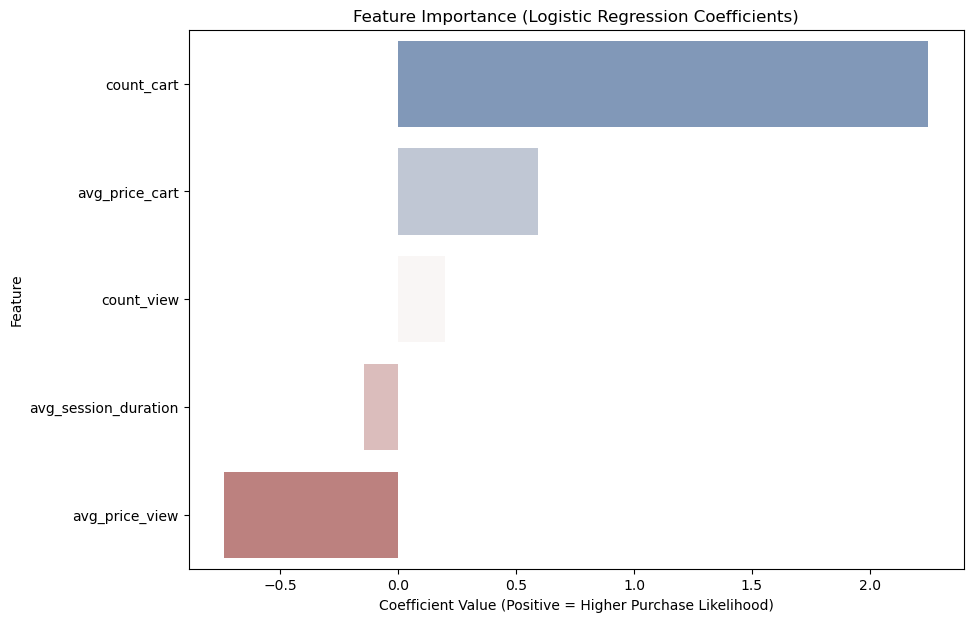

In [ ]:
# Feature importance visualization
feature_cols_for_viz = [
    "count_view",
    "count_cart",
    "avg_price_view",
    "avg_price_cart",
    "avg_session_duration"
]

lr_model = model.stages[-1]
coefficients = lr_model.coefficients.toArray()
feature_importance = pd.Series(coefficients, index=feature_cols_for_viz).sort_values(ascending=False)

plt.figure(figsize=(10, 7))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="vlag")
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value (Positive = Higher Purchase Likelihood)')
plt.ylabel('Feature')
plt.show()

In [ ]:
from pyspark.sql.functions import mean, stddev, abs as spark_abs

POSITIVE_FEATURES = ["count_cart"]
NEGATIVE_FEATURES = ["avg_price_view", "count_view"]

# Calculate aggregate statistics
stats_df = user_features.select(
    *[mean(col(f)).alias(f"{f}_mean") for f in POSITIVE_FEATURES + NEGATIVE_FEATURES],
    *[stddev(col(f)).alias(f"{f}_stddev") for f in POSITIVE_FEATURES + NEGATIVE_FEATURES]
).collect()[0]

for f in POSITIVE_FEATURES + NEGATIVE_FEATURES:
    mean_val = stats_df[f"{f}_mean"]
    stddev_val = stats_df[f"{f}_stddev"]
    if stddev_val == 0:
        user_features = user_features.withColumn(f"{f}_zscore", lit(0.0))
    else:
        user_features = user_features.withColumn(
            f"{f}_zscore",
            (col(f) - mean_val) / stddev_val
        )

print("User features DataFrame now includes Z-Scores.")
user_features.select("user_id", *[f"{f}_zscore" for f in POSITIVE_FEATURES + NEGATIVE_FEATURES]).show(5)

User features DataFrame now includes Z-Scores.


+---------+-------------------+---------------------+--------------------+
|  user_id|  count_cart_zscore|avg_price_view_zscore|   count_view_zscore|
+---------+-------------------+---------------------+--------------------+
|635697311|  4.554696640921675| -0.24682362272441022|  0.2627185233883408|
|514586028| 0.8442917860410875|   -0.708552423374463|-0.11062252624164157|
|635697490|-0.2688296704230886|  -0.7355294988468888| -0.1917836239872899|
|633408011|-0.2688296704230886|   0.6350660016723112|-0.20801584353641958|
|558398367|-0.2688296704230886| -0.31135660550623706|-0.02946142849599323|
+---------+-------------------+---------------------+--------------------+
only showing top 5 rows



In [ ]:
# High Risk/High Interest
HIGH_Z_THRESHOLD = 1.0

high_risk_interest_generic_df = user_features.filter(
    (user_features["avg_price_view_zscore"] > HIGH_Z_THRESHOLD) &
    (user_features["count_cart_zscore"] > HIGH_Z_THRESHOLD)
)

print(f"\nTotal users in High Risk/High Interest (Generic Z-Score) Group: {high_risk_interest_generic_df.count()}")
high_risk_interest_generic_df.select("user_id", "avg_price_view_zscore", "count_cart_zscore").show(5)


Total users in High Risk/High Interest (Generic Z-Score) Group: 17667


+---------+---------------------+------------------+
|  user_id|avg_price_view_zscore| count_cart_zscore|
+---------+---------------------+------------------+
|560929322|    1.124718309133405|1.2153322715291461|
|512507728|   1.0340069410744233|1.2153322715291461|
|635296255|   1.6840178680664084| 2.699494213481381|
|592532060|   2.2505065379567517|1.2153322715291461|
|595231134|   1.2246024432075766|3.0705346989694395|
+---------+---------------------+------------------+
only showing top 5 rows



In [ ]:
# Low Quality/Churn Warning
churn_warning_generic_df_fixed = user_features.filter(
    (user_features["count_view_zscore"] > HIGH_Z_THRESHOLD) &
    (user_features["count_cart"] == 0)
)

print(f"\nTotal users in Low Quality/Churn Warning Group: {churn_warning_generic_df_fixed.count()}")
churn_warning_generic_df_fixed.select("user_id", "count_view_zscore", "count_cart").show(5)


Total users in Low Quality/Churn Warning Group: 35554


+---------+------------------+----------+
|  user_id| count_view_zscore|count_cart|
+---------+------------------+----------+
|553402428|1.0418650617465648|         0|
|622692368| 1.561296087318714|         0|
|566667370|1.0743295008448241|         0|
|534213940|7.0315540753754115|         0|
|525075306| 6.739374123491078|         0|
+---------+------------------+----------+
only showing top 5 rows

